In [32]:
import json
import math
import random
from pathlib import Path
from pprint import pprint
from utils import load_dataset, create_dataset, write_test_data, gpt_prediction, eval_response, results_path

output_dir = results_path / "sentence_length_tiled_sorted_margin"
if not output_dir.exists():
    output_dir.mkdir(parents=True)
dataset, tag_counts = load_dataset("sentences.json")
print(len(dataset))
pprint(tag_counts)

200
{'all_lower': 78,
 'all_upper': 59,
 'animate': 1,
 'city': 25,
 'even_words': 97,
 'fragment_subject': 20,
 'fragment_verb': 20,
 'gpt4': 200,
 'long': 108,
 'long_margin': 60,
 'margin': 97,
 'nature': 62,
 'odd_words': 103,
 'proper_noun': 32,
 'sentence': 160,
 'shared_sample': 42,
 'short': 92,
 'short_margin': 43,
 'start_cap': 121,
 'start_consonant': 171,
 'start_lower': 79,
 'start_the': 57,
 'start_vowel': 29}


In [33]:
# fragments vs sentence; just subject/verb fragments vs all; test if class balance changes accuracy
tags_true = ["short_margin"]
tags_false = ["long_margin"]
tags_common = []
positives, negatives = create_dataset(dataset, tags_true, tags_false, tags_common, true_comb="AND", false_comb="AND")

with open(output_dir / "dataset_tags.txt", "w") as f:
    f.write(f"tags_true: {tags_true}\n")
    f.write(f"tags_false: {tags_false}\n")
    f.write(f"tags_common: {tags_common}\n")

print(len(positives), len(negatives))

43 60


In [34]:
pprint(positives)

[{'input': 'LEARNING IS A LIFELONG JOURNEY.',
  'label': True,
  'tags': ['start_cap',
           'odd_words',
           'short',
           'sentence',
           'all_upper',
           'start_consonant',
           'short_margin',
           'gpt4']},
 {'input': 'POSITIVITY BREEDS POSITIVITY.',
  'label': True,
  'tags': ['start_cap',
           'odd_words',
           'short',
           'sentence',
           'all_upper',
           'start_consonant',
           'short_margin',
           'gpt4']},
 {'input': 'creativity knows no bounds.',
  'label': True,
  'tags': ['even_words',
           'short',
           'sentence',
           'start_lower',
           'start_consonant',
           'short_margin',
           'gpt4',
           'all_lower']},
 {'input': 'BE KIND TO ONE ANOTHER.',
  'label': True,
  'tags': ['start_cap',
           'odd_words',
           'short',
           'sentence',
           'all_upper',
           'start_consonant',
           'short_margin',
        

In [35]:
pprint(negatives)

[{'input': 'IN THE END, WE WILL REMEMBER NOT THE WORDS OF OUR ENEMIES, BUT THE '
           'SILENCE OF OUR FRIENDS.',
  'label': False,
  'tags': ['start_cap',
           'long',
           'even_words',
           'long_margin',
           'sentence',
           'start_vowel',
           'all_upper',
           'gpt4']},
 {'input': 'Traffic jams and busy intersections characterized the daily rhythm '
           'of life in the bustling urban center.',
  'label': False,
  'tags': ['start_cap',
           'city',
           'long',
           'even_words',
           'long_margin',
           'sentence',
           'start_consonant',
           'gpt4']},
 {'input': 'The Great Barrier Reef is a natural wonder.',
  'label': False,
  'tags': ['start_cap',
           'long',
           'even_words',
           'nature',
           'proper_noun',
           'long_margin',
           'sentence',
           'start_consonant',
           'start_the',
           'gpt4']},
 {'input': 'gentle bre

In [36]:
sample_counts = [5, 10, 15, 30]
response_jsons = []
sort_len = lambda x: len(x.split())
for c in sample_counts:
    write_test_data(positives, negatives, c, output_dir, max_test_ct=50, tiled=True, prompt_sort_by=sort_len)
    in_context_prompt = open(output_dir / f"in_context_prompt_{c}.txt").read()
    test_prompt = open(output_dir / f"test_prompt_{c}.txt").read()
    test_samples = json.load(open(output_dir / f"test_samples_{c}.json"))
    response_json = gpt_prediction(in_context_prompt, test_prompt, json_mode=True)
    json.dump(response_json, open(output_dir / f"response_{c}.json", "w"))
    response_jsons.append(response_json)

/Users/ishangaur/classification-faithfulness/utils.py:106: UserWarning: json_mode only supported for gpt-4-1106-preview
  warn("json_mode only supported for gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:107: UserWarning: changing model to gpt-4-1106-preview
  warn("changing model to gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:110: UserWarning: json_mode is on but user_query does not contain "json"
  warn("json_mode is on but user_query does not contain \"json\"")
/Users/ishangaur/classification-faithfulness/utils.py:111: UserWarning: adding prefix to user_query:
"Please label the following inputs. Respond in JSON format like the examples given to you above."
  warn(f"adding prefix to user_query:\n\"{json_prefix}\"")


In [37]:
sample_counts = [5, 10, 15, 30]
response_jsons = [json.load(open(output_dir / f"response_{c}.json")) for c in sample_counts]
test_samples = [json.load(open(output_dir / f"test_samples_{c}.json")) for c in sample_counts]

results = []
responses = []
for r, t in zip(response_jsons, test_samples):
    response, result = eval_response(r, t)
    results.append(result)
    responses.append(response)

In [38]:
for c, r in zip(sample_counts, results):
    r["in_context_count"] = c
pprint(results)

[{'accuracy': 0.6052631578947368,
  'correct': 46,
  'corrupted': 0,
  'in_context_count': 5,
  'incorrect': 30,
  'mismatch': 0,
  'total': 76},
 {'accuracy': 0.6060606060606061,
  'correct': 40,
  'corrupted': 0,
  'in_context_count': 10,
  'incorrect': 26,
  'mismatch': 0,
  'total': 66},
 {'accuracy': 0.5892857142857143,
  'correct': 33,
  'corrupted': 0,
  'in_context_count': 15,
  'incorrect': 23,
  'mismatch': 0,
  'total': 56},
 {'accuracy': 0.7307692307692307,
  'correct': 19,
  'corrupted': 0,
  'in_context_count': 30,
  'incorrect': 7,
  'mismatch': 0,
  'total': 26}]


In [39]:
json.dump(responses, open(output_dir / "responses.json", "w"))
json.dump(results, open(output_dir / "results.json", "w"))

                   correct  mismatch  incorrect  corrupted  test_total
in_context_count                                                      
5                 0.605263       0.0   0.394737        0.0    0.938272
10                0.606061       0.0   0.393939        0.0    0.814815
15                0.589286       0.0   0.410714        0.0    0.691358
30                0.730769       0.0   0.269231        0.0    0.320988


Text(0.5, 1.0, 'Short (<7) vs Long Tiled (n=81, T=1)')

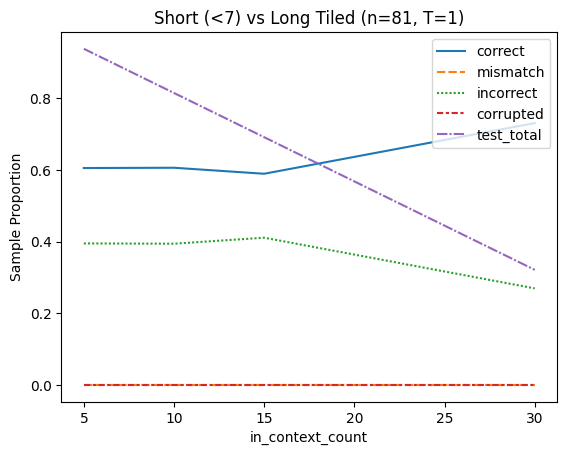

In [40]:
import pandas as pd
import seaborn as sns

results = json.load(open(output_dir / "results.json"))

df = pd.DataFrame(results)
df.drop(columns=["accuracy"], inplace=True)
total_samples = df["total"].max() + df["in_context_count"].min()

for col in df.columns:
    if col == "total":
        df[col] /= total_samples
    elif col == "in_context_count":
        continue
    else:
        df[col] /= df["total"]
df["test_total"] = df["total"]
df.drop(columns=["total"], inplace=True)
df.set_index("in_context_count", inplace=True)
print(df)

ax = sns.lineplot(data=df)
ax.set_ylabel("Sample Proportion")
ax.set_title(f"Short (<7) vs Long Tiled (n={total_samples}, T=1)")